### Plotting Test
Alex is using this Jupyter notebook to test the plotting + print statements from query.py.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lsst.rsp import get_tap_service
import sys
import os
sys.path.append(os.path.abspath('../../../sso_query/'))
import query as q
import query_helpers as qh

#### NEO plots

In [2]:
# string, class_name = q.make_query("dp03_catalogs_10yr", class_name = "NEO", cutoffs = None, join = None)
string, class_name = q.make_query("dp03_catalogs_10yr", class_name = "NEO", cutoffs = None, join = "DiaSource")
print(string)
NEO_data_table = q.run_query(string, class_name, "dp03_catalogs_10yr", to_pandas = True)

Querying dp03_catalogs_10yr.DiaSource for: ['dias.magTrueVband', 'dias.band']
SELECT mpc.incl, mpc.q, mpc.e, mpc.ssObjectID, mpc.mpcDesignation, dias.magTrueVband, dias.band FROM dp03_catalogs_10yr.MPCORB AS mpc
    INNER JOIN dp03_catalogs_10yr.DiaSource AS dias ON mpc.ssObjectId = dias.ssObjectId
    WHERE mpc.q < 1.3 AND mpc.e < 1.0 AND mpc.q/(1-mpc.e) < 4.0;
Job phase is COMPLETED
  band         e     incl  magTrueVband mpcDesignation         q  \
0    i  0.309496  9.71761     27.107683       2002 YG4  1.008779   
1    i  0.309496  9.71761     23.838692       2002 YG4  1.008779   
2    r  0.309496  9.71761     24.017090       2002 YG4  1.008779   
3    r  0.309496  9.71761     23.837805       2002 YG4  1.008779   
4    i  0.309496  9.71761     23.228445       2002 YG4  1.008779   

       ssObjectID         a class_name  
0  14288859734187  1.460932        NEO  
1  14288859734187  1.460932        NEO  
2  14288859734187  1.460932        NEO  
3  14288859734187  1.460932        NEO 

In [3]:
print(NEO_data_table.columns)

Index(['band', 'e', 'incl', 'magTrueVband', 'mpcDesignation', 'q',
       'ssObjectID', 'a', 'class_name'],
      dtype='object')


#### Now that we have our data, let's make some plots.

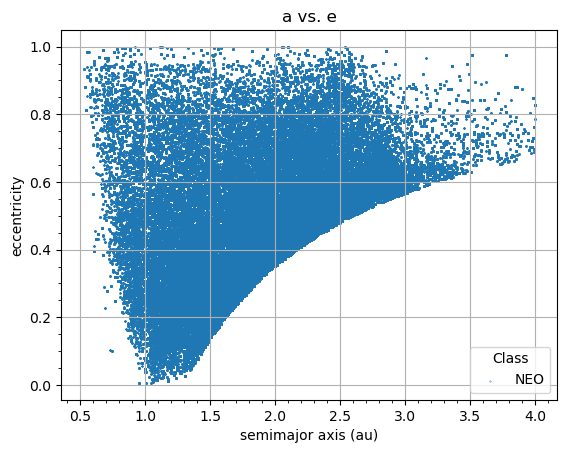

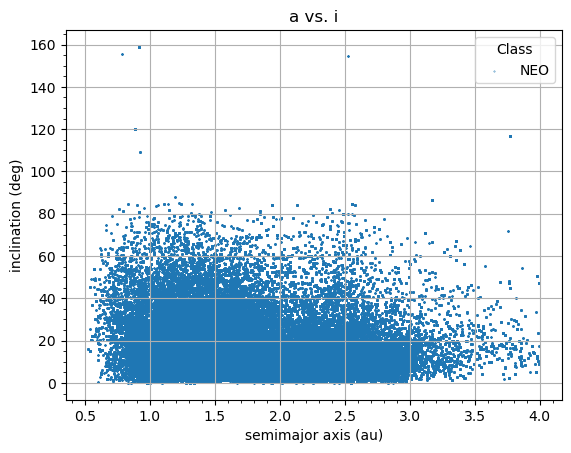

In [4]:
qh.plot_data(NEO_data_table)

In [5]:
df = NEO_data_table
print(df['class_name'].value_counts())

class_name
NEO    2135926
Name: count, dtype: int64


#### How many observations for each object? In what filters?
To get observations by filter, make sure your query is joined with DiaSource.

In [6]:
# # need to count observations for each unique object in SSO_id
# print(df['ssObjectID'].value_counts())
# # unique observations within each filter
# print(df['band'].value_counts())
# # count of unique observations for each unique object in SSO_id within each filter
# temp = df.groupby(['ssObjectID', 'band']).size().reset_index(name='obs_filter_count')
# print(df.groupby(['ssObjectID', 'band']).size().reset_index(name='obs_filter_count'))
# print(temp.columns)

observations_by_object_filter = qh.obs_filter(df)

# of observations by Object: ssObjectID
-6531816816762911299    1708
-7495537061370576217    1316
-8960445666237157474    1084
 5885925787919145121     993
-3541095373223286452     991
                        ... 
-1714279339900084768       6
-2146436843919977555       6
 2889461387989487544       6
 7149114482363885790       6
 339343444868464144        6
Name: count, Length: 39470, dtype: int64
# of observations by Filter: band
r    754794
i    686043
z    419419
g    275670
Name: count, dtype: int64
# of unique observations for each unique object, by filter:                  ssObjectID band  obs_filter_count
0      -9222952578217572358    g                 4
1      -9222952578217572358    i                11
2      -9222952578217572358    r                12
3      -9222952578217572358    z                 6
4      -9222820784385736130    g                 7
...                     ...  ...               ...
153755  9222765823057774610    z                 4
153756  9222996671474961

#### What is the average magnitude range? Does any object have an unusually large range?

Want to group everything by its object type, then group the observations by object, then want to get the min/max brightnesses from each object, then want to get average min/max values, then if something is more than one std.dev away, want to call it out. 

In [7]:
%load_ext autoreload

df.columns
sorted_ranges = qh.data_grouped_mags(df)
# obs_filter(df)
mag_range_plot(sorted_ranges, head_number = 5)



NameError: name 'np' is not defined

In [14]:
data_grouped_mags(df):
"""
Function groups everything by class name, observations by unique object, gets min/max mags
Args:
    df (Pandas Dataframe): Results data with columns 'class_name', 'ssObjectID'
Returns:
    sorted_filt_lrg_ranges (Pandas df): Original dataframe grouped by class name and unique observation, added min/max/mean/range magnitude columns,
        filtered by 2 std deviation criterion in mag range, in a descending order according to mag range column.
"""

# Check that object_type and ssObjectID are actual columns

# 1. Group observations by object type, by ssObjectID, get the min/max/mean magnitudes
grouped_obs_data = df.groupby(['class_name', 'ssObjectID']).agg(
    mag_min = ('magTrueVband', 'min'), 
    mag_max = ('magTrueVband', 'max'), 
    mag_mean = ('magTrueVband', 'mean')
)
grouped_obs_data = grouped_obs_data.reset_index() # groupby turns 'class_name' and 'ssObjectID' into indeces, this turns them back into columns
# print(grouped_obs_data) # degbugging

# 2. Create ranges column from min/max magnitudes, get standard deviation of ranges. 
# want to look at when the range has a larger spread than normal, so want to get the std. deviation of the range
mag_range = grouped_obs_data["mag_max"] - grouped_obs_data["mag_min"]
# print(mag_range) # debugging
grouped_obs_data['mag_range'] = mag_range
print("Standard Deviation of Range:", np.std(mag_range))
print("Mean Range:", np.mean(mag_range))

# 3. Need to check which ranges are above change criterion. Using mean and std. deviation by object_type. 
large_criterion = np.mean(mag_range) + (np.std(mag_range)*2)
print(f"Large range criterion:", large_criterion)
filtered_large_ranges = grouped_obs_data[grouped_obs_data['mag_range'] > large_criterion]
# print(filtered_large_ranges) # debugging
# print(filtered_large_ranges.columns) #debugging

# 4. Rearranging dataframe so magnitude ranges are in descending order (largest at the top).
sorted_filt_lrg_ranges = filtered_large_ranges.sort_values(by='mag_range', ascending=False)
# print(sorted_filt_lrg_ranges) # debugging

return sorted_filt_lrg_ranges

      object_type           ssObjectID    mag_min    mag_max   mag_mean
0             NEO -9222952578217572358  20.865181  28.316063  22.341082
1             NEO -9222820784385736130  21.404852  29.954420  25.140797
2             NEO -9222809672762914664  29.152020  31.880566  30.732315
3             NEO -9222638543944259679  20.660261  20.916206  20.807749
4             NEO -9222469573562197566  21.441607  25.298536  22.376635
...           ...                  ...        ...        ...        ...
39465         NEO  9221626825731835023  21.376930  26.843601  23.258450
39466         NEO  9222267589414335277  18.893867  23.640882  21.959656
39467         NEO  9222476822316093977  18.088520  24.029242  22.102621
39468         NEO  9222765823057774610  27.979145  29.599825  28.464285
39469         NEO  9222996671474961129  22.383114  23.973074  22.934273

[39470 rows x 5 columns]


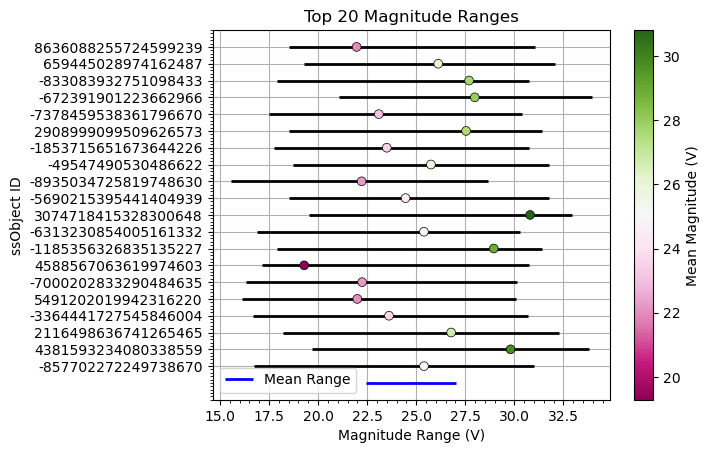

In [25]:
# getting top 10 ranges
top_srtd_filt_lrg_ranges = sorted_filt_lrg_ranges.iloc[:20,:]
top_ranges = top_srtd_filt_lrg_ranges.copy()
top_ranges['y_spacing'] = range(1, len(top_ranges) + 1) 
# print(top_ranges) #degbugging


# For the largest objects, want to visualize their ranges
fig, ax = plt.subplots()
ax.hlines(data = top_ranges, y = 'y_spacing', xmin = 'mag_min', xmax = 'mag_max', color = "black", linewidth = 2, zorder = 2, label = None)

# adding reference line
x_center = (top_ranges['mag_min'].min() + top_ranges['mag_max'].max()) / 2
xmin_ref = x_center - (np.mean(mag_range/2))
xmax_ref = x_center + (np.mean(mag_range/2))
ax.hlines(y = 0, xmin = xmin_ref, xmax = xmax_ref, color = "blue", linewidth = 2, label = "Mean Range") #want this to be in the center of the plot
# print("Mean Range:", np.mean(mag_range))
sc = ax.scatter(data = top_ranges, x = 'mag_mean', y = 'y_spacing', s = 40, marker='o', edgecolors = "black", linewidth = 0.5, c='mag_mean', cmap = 'PiYG', zorder = 3, label = None)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Mean Magnitude (V)')
ax.set_xlabel('Magnitude Range (V)')
ax.set_ylabel('ssObject ID')
ax.set_title("Top 20 Magnitude Ranges")
ax.set_yticks(top_ranges['y_spacing'])
ax.set_yticklabels(top_ranges['ssObjectID'])
ax.minorticks_on()
ax.grid(zorder = 1)
plt.legend(loc="lower left")
plt.show()


# plt.scatter('x', 'y', s='size', c='density', data=df, alpha=0.5, cmap='Blues')

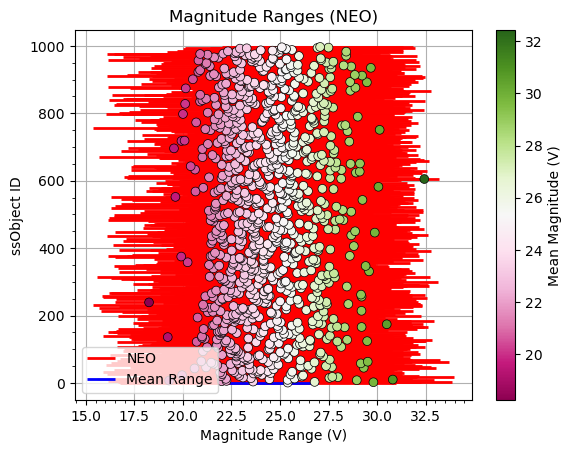

In [32]:
# just plotting all of the NEOs above 2 sigma
data_table = sorted_filt_lrg_ranges

top_srtd_filt_lrg_ranges = sorted_filt_lrg_ranges.iloc[:10,:]
top_ranges = data_table.copy()
top_ranges['y_spacing'] = range(1, len(top_ranges) + 1) 
# print(top_ranges) #degbugging

color_map = {
    "NEO": "red",
    "TNO": "blue",
    "Centaur": "green",
    "MBA": "orange",
    "Jtrojan": "purple",
    "LPC": "brown",
    "Ntrojan": "pink"
}

color = color_map.get(object_type, "gray")  # fallback to 'gray' if type unknown
# For the largest objects, want to visualize their ranges
fig, ax = plt.subplots()
ax.hlines(data = top_ranges, y = 'y_spacing', xmin = 'mag_min', xmax = 'mag_max', color = color, linewidth = 2, zorder = 2, label = object_type)

# adding reference line
x_center = (top_ranges['mag_min'].min() + top_ranges['mag_max'].max()) / 2
xmin_ref = x_center - (np.mean(mag_range/2))
xmax_ref = x_center + (np.mean(mag_range/2))
ax.hlines(y = 0, xmin = xmin_ref, xmax = xmax_ref, color = "blue", linewidth = 2, label = "Mean Range") #want this to be in the center of the plot
# print("Mean Range:", np.mean(mag_range))
sc = ax.scatter(data = top_ranges, x = 'mag_mean', y = 'y_spacing', s = 40, marker='o', edgecolors = "black", linewidth = 0.5, c='mag_mean', cmap = 'PiYG', zorder = 3, label = None)
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Mean Magnitude (V)')
ax.set_xlabel('Magnitude Range (V)')
ax.set_ylabel('ssObject ID')
ax.set_title("Magnitude Ranges")
# ax.set_yticks(top_ranges['y_spacing'])
# ax.set_yticklabels(top_ranges['ssObjectID'])
ax.minorticks_on()
ax.grid(zorder = 1)
plt.legend(loc="lower left")
plt.show()

In [26]:
# sorted_filt_lrg_ranges.columns

# q.mag_range_plot(sorted_filt_lrg_ranges, number = 5)
# q.mag_range_plot(sorted_filt_lrg_ranges, number = 40)
# q.mag_range_plot(sorted_filt_lrg_ranges, number = None)